## Imports 

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
import os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import cv2
from sklearn.model_selection import train_test_split



## Dataset Preparation 

In [7]:
DATA_DIR = "/kaggle/input/gtsrb-german-traffic-sign"

TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR  = os.path.join(DATA_DIR, "Test")
META_DIR  = os.path.join(DATA_DIR, "Meta")

TRAIN_CSV = os.path.join(DATA_DIR, "Train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "Test.csv")
META_CSV  = os.path.join(DATA_DIR, "Meta.csv")

print("✅ All imports ready!")
print("📂 Train folder:", TRAIN_DIR)
print("📂 Test folder :", TEST_DIR)
print("📂 Meta folder :", META_DIR)

✅ All imports ready!
📂 Train folder: /kaggle/input/gtsrb-german-traffic-sign/Train
📂 Test folder : /kaggle/input/gtsrb-german-traffic-sign/Test
📂 Meta folder : /kaggle/input/gtsrb-german-traffic-sign/Meta


## Preprocessing

In [11]:
IMG_SIZE = 32
NUM_CLASSES = 43

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
meta_df  = pd.read_csv(META_CSV)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("Meta shape :", meta_df.shape)

# Preprocess function
def preprocess_img(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None  # 🔥 skip if not found
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

# Training data
X, y = [], []
missing = 0
for idx, row in train_df.iterrows():
    img_path = os.path.join(DATA_DIR, row['Path'])
    img = preprocess_img(img_path)
    if img is None:
        missing += 1
        continue
    X.append(img)
    y.append(row['ClassId'])

X = np.array(X)
y = tf.keras.utils.to_categorical(np.array(y), num_classes=NUM_CLASSES)

print(f"✅ Loaded {len(X)} training images | Skipped {missing} missing files")

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, y_train.shape)
print("Val set  :", X_val.shape, y_val.shape)

# Test data
X_test, y_test = [], []
missing_test = 0
for idx, row in test_df.iterrows():
    img_path = os.path.join(DATA_DIR, row['Path'])
    img = preprocess_img(img_path)
    if img is None:
        missing_test += 1
        continue
    X_test.append(img)
    y_test.append(row['ClassId'])

X_test = np.array(X_test)
y_test = tf.keras.utils.to_categorical(np.array(y_test), num_classes=NUM_CLASSES)

print(f"✅ Loaded {len(X_test)} test images | Skipped {missing_test} missing files")
print("Final shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train shape: (39209, 8)
Test shape : (12630, 8)
Meta shape : (43, 5)
✅ Loaded 39209 training images | Skipped 0 missing files
Train set: (31367, 32, 32, 3) (31367, 43)
Val set  : (7842, 32, 32, 3) (7842, 43)
✅ Loaded 12630 test images | Skipped 0 missing files
Final shapes -> Train: (31367, 32, 32, 3) Val: (7842, 32, 32, 3) Test: (12630, 32, 32, 3)


## Visualizations (EDA) 

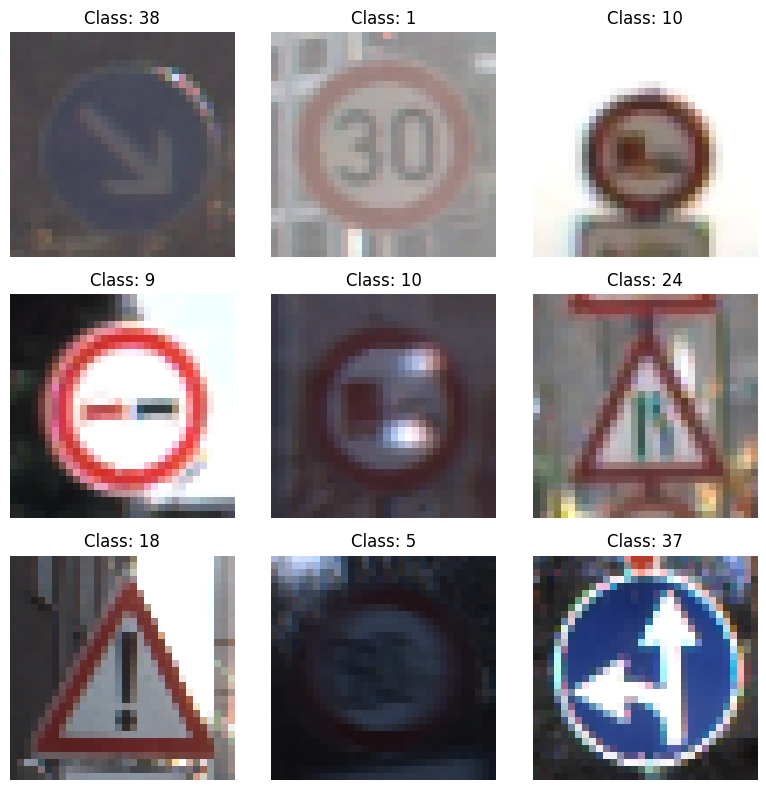

In [14]:
# =========================
# 👀 Visualize Sample Images
# =========================

import random

# Pick 9 random samples
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for ax in axes.flat:
    idx = random.randint(0, len(X_train)-1)
    ax.imshow(X_train[idx])
    label = np.argmax(y_train[idx])  # back from one-hot
    ax.set_title(f"Class: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Augmentation (train only)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,   # traffic signs shouldn't flip
    fill_mode='nearest'
)
val_datagen  = ImageDataGenerator()  # no aug
test_datagen = ImageDataGenerator()  # no aug

# Generators
BATCH_SIZE = 64
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_generator   = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
test_generator  = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

# Optimizer (Adam) + adaptive LR
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1
)

callbacks = [lr_scheduler, early_stop]

print("✅ Augmentation + Adam optimizer + callbacks ready.")


✅ Augmentation + Adam optimizer + callbacks ready.


I0000 00:00:1756077201.751589      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756077201.752234      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Model and Predictions

In [19]:
def build_model(cfg, img_size, num_classes):
    aug = make_aug_layer(cfg, img_size)
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = aug(inputs, training=True)

    if cfg["model"] == "mobilenetv2":
        base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights="imagenet")
        base.trainable = False if cfg["fine_tune_at"] is None else True
        if cfg["fine_tune_at"] is not None:
            for l in base.layers[:cfg["fine_tune_at"]]:
                l.trainable = False
        y = base(x, training=False)
        y = layers.GlobalAveragePooling2D()(y)
        y = layers.Dropout(cfg["dropout"])(y)
        outputs = layers.Dense(num_classes, activation="softmax")(y)
        return models.Model(inputs, outputs)

    # --- Simple CNN with correct BN/Pooling calls ---
    y = layers.Conv2D(32, (3,3), activation='relu', padding="same")(x)
    y = layers.BatchNormalization()(y)
    y = layers.MaxPooling2D()(y)

    y = layers.Conv2D(64, (3,3), activation='relu', padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.MaxPooling2D()(y)

    y = layers.Conv2D(128, (3,3), activation='relu', padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.MaxPooling2D()(y)

    y = layers.Flatten()(y)
    y = layers.Dense(256, activation='relu')(y)
    y = layers.Dropout(cfg["dropout"])(y)
    outputs = layers.Dense(num_classes, activation='softmax')(y)
    return models.Model(inputs, outputs)

# Rebuild, compile, and continue training with your existing CFG/train_ds/val_ds/test_ds
model = build_model(CFG, IMG_SIZE, NUM_CLASSES)
opt = tf.keras.optimizers.Adam(learning_rate=CFG["base_lr"])
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

callbacks = make_callbacks(CFG)
history = model.fit(train_ds, validation_data=val_ds, epochs=CFG["epochs"], callbacks=callbacks, verbose=1)

test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")
model.save(CFG["save_name"]); print(f"💾 Saved: {CFG['save_name']}")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629,739 (2.40 MB)

 Trainable params: 629,291 (2.40 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30


I0000 00:00:1756077567.912313     150 cuda_dnn.cc:529] Loaded cuDNN version 90300


491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2776 - loss: 2.7983
Epoch 1: val_loss improved from inf to 1.50809, saving model to gtsrb_model_adaptive.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2778 - loss: 2.7968 - val_accuracy: 0.5399 - val_loss: 1.5081 - learning_rate: 0.0010
Epoch 2/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6363 - loss: 1.1047
Epoch 2: val_loss improved from 1.50809 to 0.40147, saving model to gtsrb_model_adaptive.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6365 - loss: 1.1041 - val_accuracy: 0.8655 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 3/30
489/491 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7999 - loss: 0.6083
Epoch 3: val_loss improved from 0.40147 to 0.27968, saving model to gtsrb_model_adaptive.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8000 - loss: 0.6079 - val_accuracy: 0.8991 - val_loss: 0.2797 - learning_rate: 0.0010
Epoch 4/30
489/491 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

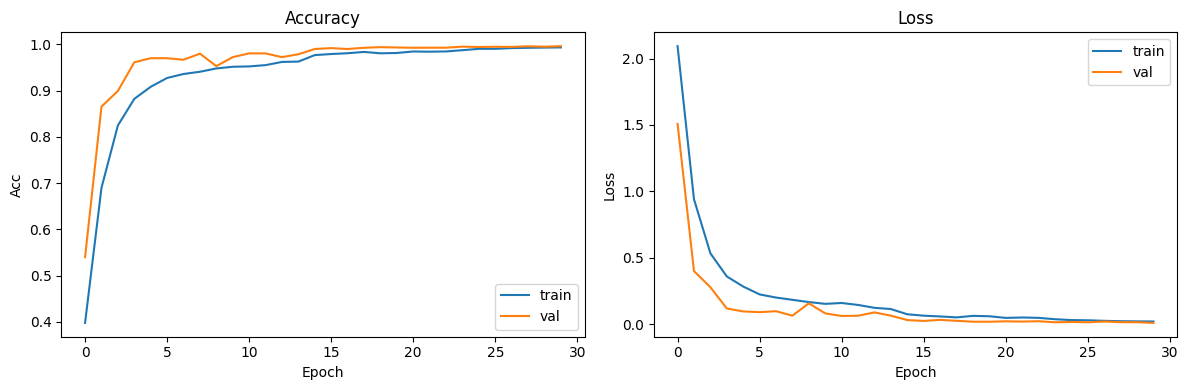

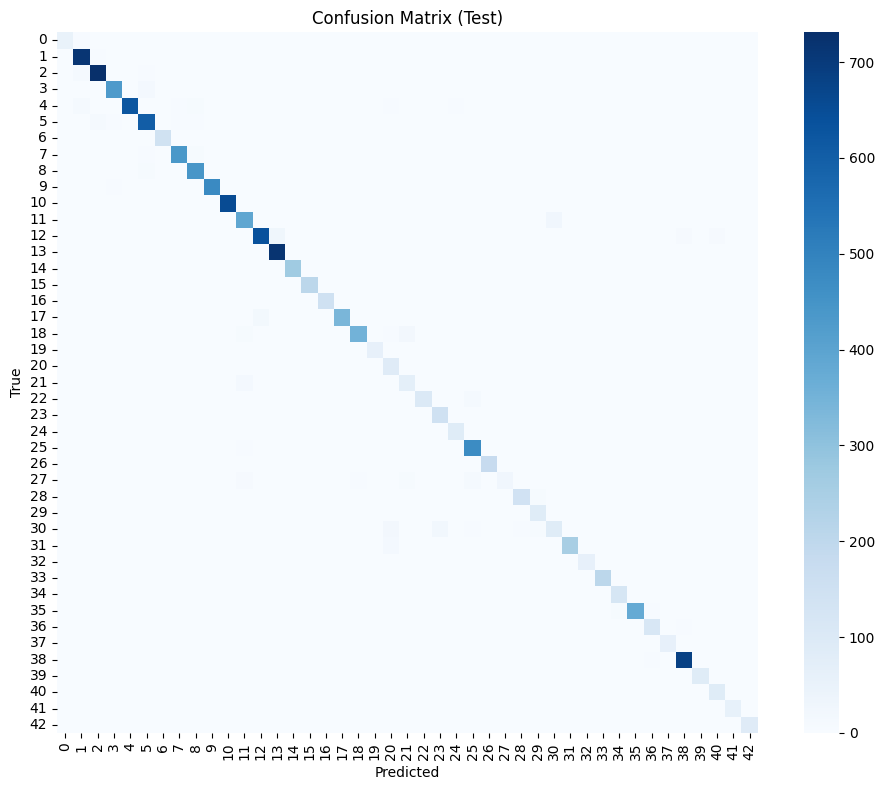

,precision,recall,f1-score,support
accuracy,0.961679,0.961679,0.961679,0.961679
macro avg,0.948048,0.944822,0.942635,12630.000000
weighted avg,0.963280,0.961679,0.961252,12630.000000


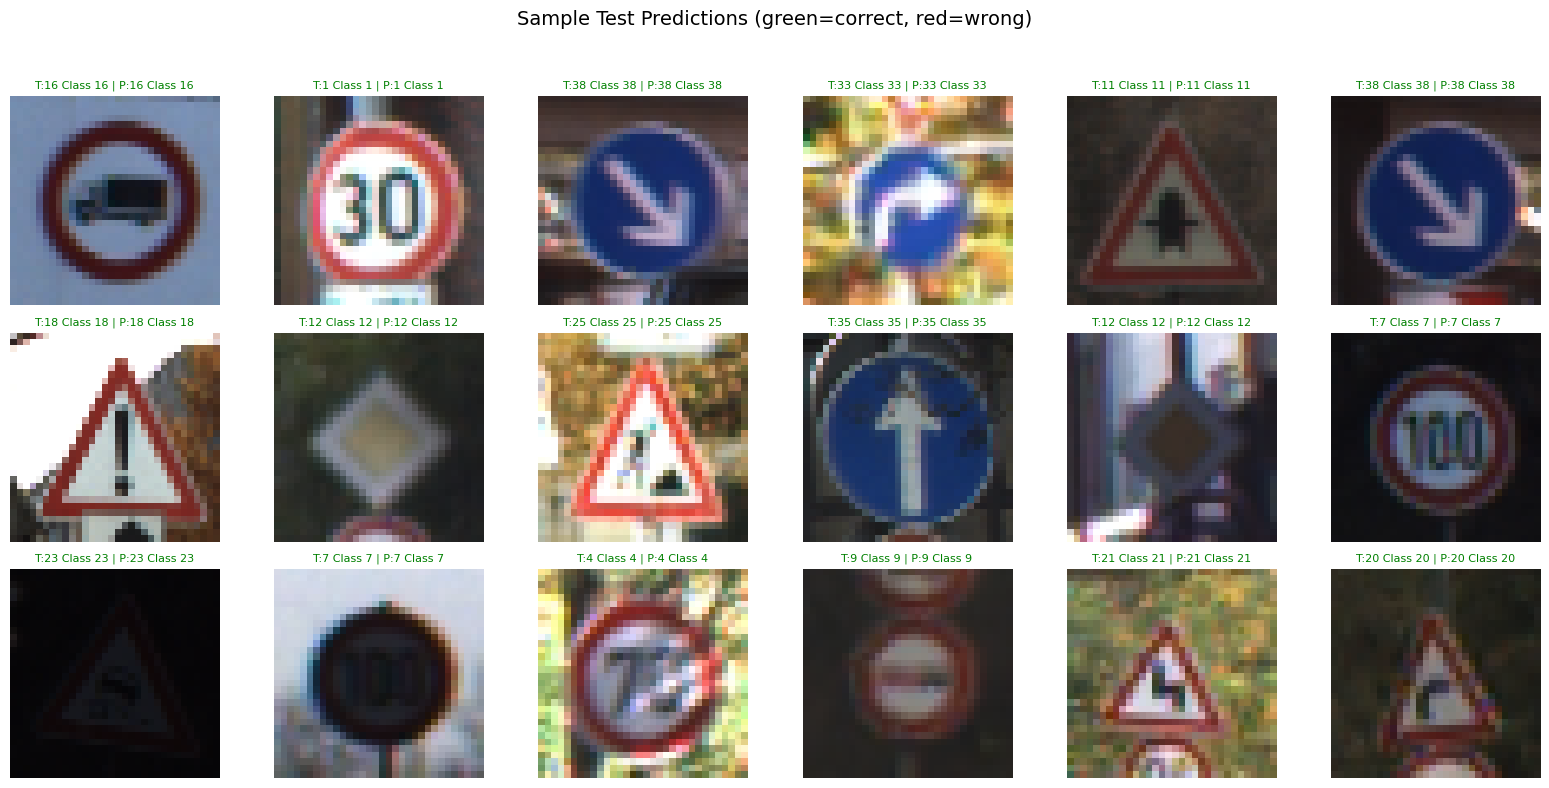

💾 Saved model → Traffic_Sign_Prediction.h5
💾 Saved: gtsrb_classification_report.csv, gtsrb_confusion_matrix.npy, gtsrb_training_history.csv


In [22]:
# =========================
# 📊 Evaluate, Visualize, Save (robust to Meta.csv schema)
# =========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 0) Robust class-name mapping from Meta.csv
mdf = meta_df.copy()
mdf.columns = mdf.columns.str.strip()
lc = {c: c.lower() for c in mdf.columns}
# find id column
id_col = next((c for c in mdf.columns if lc[c] in ["classid","class_id","class","id"]), None)
# find name column (various dataset variants)
name_col = next((c for c in mdf.columns if lc[c] in ["signname","name","classname","class_name","label"]), None)

if id_col is not None and name_col is not None:
    id2name = dict(zip(mdf[id_col].astype(int), mdf[name_col].astype(str)))
else:
    # fallback: numeric to string id
    id2name = {i: f"Class {i}" for i in range(y_train.shape[1])}

# 1) Training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(history.history['accuracy'], label='train'); plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend()
plt.subplot(1,2,2); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout(); plt.show()

# 2) Predictions on test set
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", square=True, cbar=True)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# 4) Classification report
report = classification_report(y_true, y_pred, output_dict=True, digits=4)
report_df = pd.DataFrame(report).T
display(report_df.tail(3))  # accuracy / macro avg / weighted avg

# 5) Sample predictions grid
samples, labels = [], []
for xb, yb in test_ds.take(1):
    samples = xb.numpy(); labels = np.argmax(yb.numpy(), axis=1)
preds = np.argmax(model.predict(samples, verbose=0), axis=1)

rows, cols = 3, 6
plt.figure(figsize=(16,8))
for i in range(min(rows*cols, len(samples))):
    plt.subplot(rows, cols, i+1)
    plt.imshow(samples[i])
    t, p = int(labels[i]), int(preds[i])
    t_name, p_name = id2name.get(t, str(t)), id2name.get(p, str(p))
    plt.title(f"T:{t} {t_name[:10]} | P:{p} {p_name[:10]}", fontsize=8,
              color=("green" if t==p else "red"))
    plt.axis("off")
plt.suptitle("Sample Test Predictions (green=correct, red=wrong)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

# 6) Save artifacts  ✅ fixed
Traffic_Sign_Prediction = "Traffic_Sign_Prediction.h5"  # keep the name you want

model.save(Traffic_Sign_Prediction)
report_df.to_csv("gtsrb_classification_report.csv", index=True)
np.save("gtsrb_confusion_matrix.npy", cm)
pd.DataFrame(history.history).to_csv("gtsrb_training_history.csv", index=False)

print(f"💾 Saved model → {Traffic_Sign_Prediction}")
print("💾 Saved: gtsrb_classification_report.csv, gtsrb_confusion_matrix.npy, gtsrb_training_history.csv")

